# Plateau Width Analysis

In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np
from raccoon.utils.annotationutils import trigger_points

# Clean ECG Signals
signal_dir = "../data/mitdb"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

clean_records, triggers = read_records(signal_dir, names, sampto)
clean_records, triggers = np.array(clean_records), np.array(triggers)

# Noise template
noise_path = '../data/noises/em'
noise_template = wfdb.rdrecord(noise_path)

## Add Noise

In [4]:
from raccoon.utils.noiseutils import apply_noise_db

noisy_records = [
    apply_noise_db(clean_record, noise_template, 3)
    for clean_record in clean_records]

noisy_records = np.array(noisy_records)

## Create Detector

In [5]:
from raccoon.detectors import XiangDetector

xd = XiangDetector(
    name='XD', batch_size=32, window_size=40, detection_size=30,
    aux_ratio=5, epochs=3)

Using TensorFlow backend.


## Train and Test

In [6]:
from contextlib import redirect_stdout
from io import StringIO
from sklearn.model_selection import LeaveOneOut
from raccoon.utils.evaluationutils import trigger_metrics
from raccoon.utils.triggerutils import signal_to_points

cv = LeaveOneOut()

min_plateau_widths = range(31)

metrics = []
trigger_signals = []

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))
    
    train_records = clean_records[train_indexes]
    train_triggers = triggers[train_indexes]
    test_record = noisy_records[test_indexes][0]
    test_trigger = triggers[test_indexes][0]
    
    xd.reset()
    
    with redirect_stdout(StringIO()):
        xd.train(train_records, train_triggers)
    
    trigger_signal = xd.trigger_signal(test_record)
    trigger_signals.append(trigger_signal)
    detected_triggers = [
        signal_to_points(trigger_signal, min_width=mpw)
        for mpw in min_plateau_widths]
    
    metrics.append([trigger_metrics(test_trigger, detected_trigger, 5)
                    for detected_trigger in detected_triggers])

Step 1/10: [0]
Step 2/10: [1]
Step 3/10: [2]
Step 4/10: [3]
Step 5/10: [4]
Step 6/10: [5]
Step 7/10: [6]
Step 8/10: [7]
Step 9/10: [8]
Step 10/10: [9]


## Plot Example

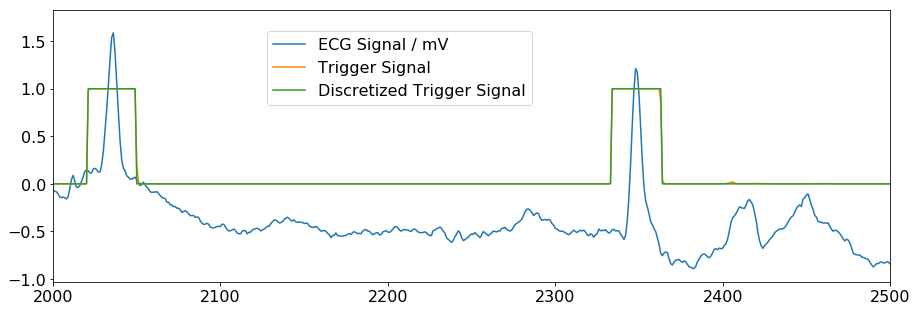

In [7]:
import matplotlib.pyplot as plt
from raccoon.utils.triggerutils import discretize

plt.rcParams.update({'font.size': 16})

example_fig, ax = plt.subplots()
example_fig.set_size_inches(15, 5)

ax.plot(noisy_records[1].p_signal.T[0], label="ECG Signal / mV")
ax.plot(trigger_signals[1], label="Trigger Signal")
ax.plot(discretize(trigger_signals[1]), label="Discretized Trigger Signal")
ax.set_xlim(2000, 2500)

example_fig.legend(bbox_to_anchor=(0., 0.3, 0.5, 0.5))

plt.show()

In [8]:
# example_fig.savefig(
#     '../../msc-thesis/thesis/images/noise_in_trigger_signal.png',
#     bbox_inches = 'tight',
#     pad_inches = 0)

## Calculate Statistics

In [9]:
from raccoon.utils.evaluationutils import sensitivity, ppv, f1

ses = np.array([
    [sensitivity(tp, fn) for tp, tn, fp, fn in test_result]
    for test_result in metrics])

ppvs = np.array([
    [ppv(tp, fp) for tp, tn, fp, fn in test_result]
    for test_result in metrics])

f1s = np.array([
    [f1(tp, fp, fn) for tp, tn, fp, fn in test_result]
    for test_result in metrics])

In [10]:
se_medians = np.nanmedian(ses, axis=0)
se_percentiles = [
    se_medians - np.nanpercentile(ses, 25, axis=0),
    np.nanpercentile(ses, 75, axis=0) - se_medians]

ppv_medians = np.nanmedian(ppvs, axis=0)
ppv_percentiles = [
    ppv_medians - np.nanpercentile(ppvs, 25, axis=0),
    np.nanpercentile(ppvs, 75, axis=0) - ppv_medians]

f1_medians = np.nanmedian(f1s, axis=0)
f1_percentiles = [
    f1_medians - np.nanpercentile(f1s, 25, axis=0),
    np.nanpercentile(f1s, 75, axis=0) - f1_medians]

## Plot

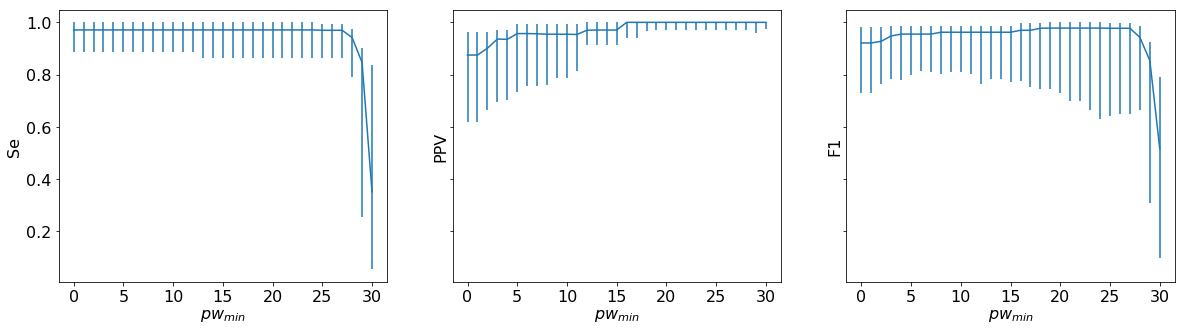

In [14]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
ticks = [0, 5, 10, 15, 20, 25, 30]

fig, (ax_se, ax_ppv, ax_f1) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(20,5)

ax_se.errorbar(min_plateau_widths, se_medians, yerr=se_percentiles)
ax_se.set_xticks(ticks)
ax_se.set_xlabel(r"$pw_{min}$")
ax_se.set_ylabel("Se")

ax_ppv.errorbar(min_plateau_widths, ppv_medians, yerr=ppv_percentiles)
ax_ppv.set_xticks(ticks)
ax_ppv.set_xlabel(r"$pw_{min}$")
ax_ppv.set_ylabel("PPV")

ax_f1.errorbar(min_plateau_widths, f1_medians, yerr=f1_percentiles)
ax_f1.set_xticks(ticks)
ax_f1.set_xlabel(r"$pw_{min}$")
ax_f1.set_ylabel("F1")

plt.show()

In [12]:
# fig.savefig(
#     '../../msc-thesis/thesis/images/mpw_stats.png',
#     bbox_inches = 'tight',
#     pad_inches = 0)

In [15]:
# fig.savefig(
#     '../../msc-thesis/thesis/images/mpw_stats_2.png',
#     bbox_inches = 'tight',
#     pad_inches = 0)